In [4]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf


In [7]:
#Importing the stock data using yahoo finance
df = yf.download('AMZN', start='2010-01-01', end='2020-12-01')
df.shape

[*********************100%***********************]  1 of 1 completed


(2747, 6)

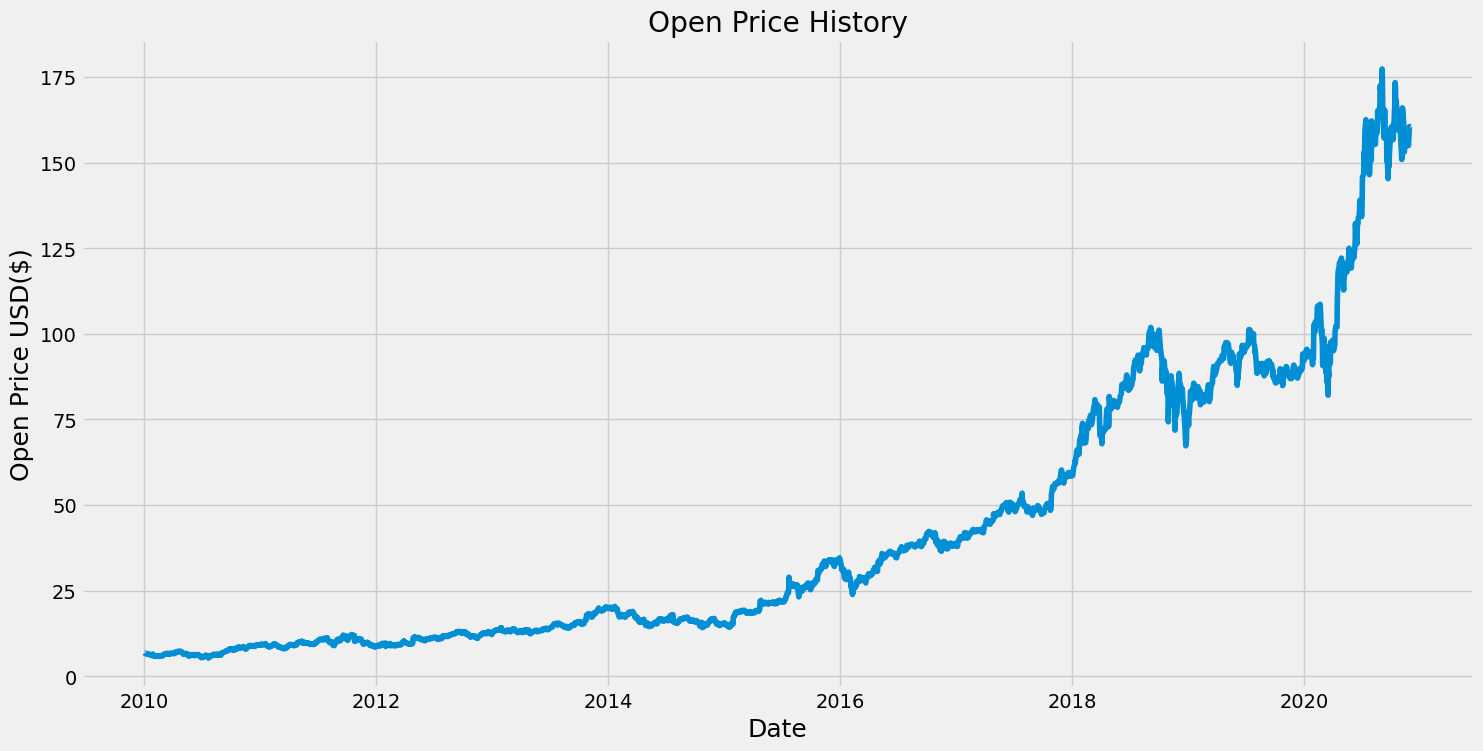

In [10]:
#Visualizing the opening price history

plt.figure(figsize=(16,8))
plt.title('Open Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Open Price USD($)', fontsize = 18)
plt.show()

In [12]:
#create a new dataframe with only Open column
data = df.filter(['Open'])
#convert dataset into numpy array
dataset = data.values
#Get the number of rows to train the model on now using 80% of the given data set 
training_data_len = math.ceil(len(dataset)* 0.8)

training_data_len

2198

In [16]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00881121],
       [0.0079917 ],
       [0.00833171],
       ...,
       [0.88226627],
       [0.9024315 ],
       [0.90162357]])

In [20]:
#creating training data set
#create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()


[array([0.00881121, 0.0079917 , 0.00833171, 0.00757904, 0.00715766,
       0.00775631, 0.0067014 , 0.00638464, 0.00674499, 0.00675662,
       0.00592257, 0.00616087, 0.00619865, 0.00571625, 0.00469912,
       0.00425158, 0.00438817, 0.00537623, 0.00692808, 0.00501297,
       0.00373721, 0.00325189, 0.00369362, 0.00289154, 0.00390867,
       0.00356575, 0.00350763, 0.00327805, 0.00379533, 0.00410628,
       0.00323736, 0.00287992, 0.00348147, 0.00332455, 0.00351053,
       0.003496  , 0.00355703, 0.00347276, 0.00371105, 0.00554479,
       0.00565812, 0.00582667, 0.00674209, 0.00650088, 0.00687577,
       0.00673628, 0.00712569, 0.00821547, 0.00748895, 0.00735527,
       0.00769528, 0.00729134, 0.00807307, 0.00705304, 0.00725356,
       0.00659969, 0.00674499, 0.00841889, 0.00855548, 0.008663  ])]
[0.008738560582640616]

[array([0.00881121, 0.0079917 , 0.00833171, 0.00757904, 0.00715766,
       0.00775631, 0.0067014 , 0.00638464, 0.00674499, 0.00675662,
       0.00592257, 0.00616087, 0.0

In [24]:
#convert the training dataset to numpy arrays to train the LSTM model

x_train, y_train = np.array(x_train), np.array(y_train)

x_train.shape

(2138, 60)

In [26]:
#Reshape the data( as LSTM requires the data to be in 3 dimension no of samples ,no of time-steps and no of features )

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train.shape

(2138, 60, 1)

In [27]:
#Building the LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [28]:
model.compile(optimizer='adam', loss= 'mean_squared_error')

In [29]:
#Training the model on the dataset
model.fit(x_train, y_train, batch_size=1, epochs=1)

2138/2138 [==============================] - 40s 16ms/step - loss: 3.1769e-04


In [33]:
#creating the testing data set

test_data = scaled_data[training_data_len - 60: , : ]
x_test =[]
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])


In [35]:
#converting the list into a numpy array
x_test = np.array(x_test)
#Reshaping for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))


In [36]:
#get the model pridicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

18/18 [==============================] - 1s 15ms/step


In [37]:
#geting the root mean square error

rms = np.sqrt(np.mean(predictions - y_test)**2)
rms

5.460070125392226

C:\Users\athar\AppData\Local\Temp\ipykernel_8028\3552283429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<function matplotlib.pyplot.show(close=None, block=None)>

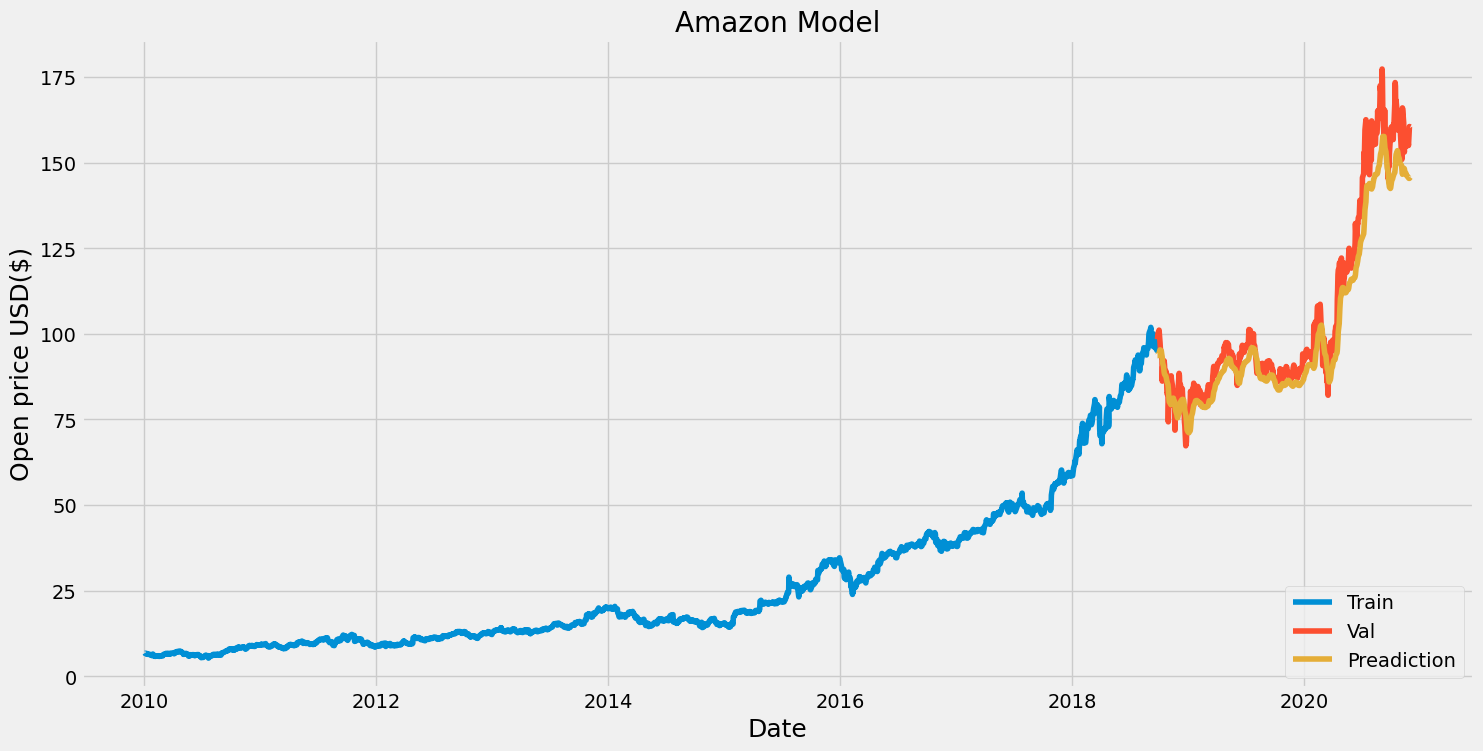

In [39]:
#ploting the data
train = data[ :training_data_len]
valid = data[training_data_len: ]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Amazon Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Open price USD($)', fontsize = 18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val' , 'Preadiction'], loc = 'lower right')
plt.show